# Text Processing TweetEval

## Import & Setup

In [1]:
# Text processing & utilities
import pandas as pd
import re
import emoji
import time
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP: Translate, Stem, Stopword
from deep_translator import GoogleTranslator
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Visualization setting
pd.set_option('display.max_colwidth', None)

## Define Utility Functions

### Emoji Cleaning

In [2]:
def remove_emoji(text):
    return emoji.replace_emoji(text, replace="") if isinstance(text, str) else text

In [3]:
def extract_emoji_description(text):
    return emoji.demojize(text) if isinstance(text, str) else text

In [4]:
def clean_emoji_desc(text):
    if isinstance(text, str):
        return text.replace("::", " ").replace(":", "").replace("-", " ").replace("_", " ")
    return text

### Text Cleaning

In [5]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s-]", "", text).replace("-", " ")
    text = re.sub(r"\b(rt|user|hashtag|shashtag|ufc|co|uk|<user>|<hashtag>)\b", "", text)
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\n", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### Translate

In [6]:
def translate_text(text, source='en', target='id', retries=3):
    for attempt in range(retries):
        try:
            return GoogleTranslator(source=source, target=target).translate(text)
        except Exception as e:
            print(f"Translation error: {e}, retry {attempt+1}")
            time.sleep(5)
    return ""

In [7]:
def translate_column(df, col, new_col):
    df[new_col] = df[col].apply(lambda x: translate_text(x))
    return df

### Slang replace 

In [8]:
def replace_slang_words(text, slang_map):
    return " ".join([slang_map.get(word, word) for word in text.split()])

### Stemming & Stopword Removal

In [9]:
stemmer = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

In [10]:
def preprocess_indonesian(text):
    return stopword.remove(stemmer.stem(text))

## Load Dataset & Emoji Preprocessing

In [11]:
df = pd.read_csv('dataset/TwEv/train_emoji.csv')
df["tweet without emoji"] = df["text"].apply(remove_emoji)
df["emoji description"] = df["emoji"].apply(extract_emoji_description).apply(clean_emoji_desc)
df["cleaned tweet"] = df["tweet without emoji"].apply(clean_text)

## Translate Cleaned Tweet and Emoji

In [ ]:
df = translate_column(df, "cleaned tweet", "translated tweet")
df = translate_column(df, "emoji description", "translated emoji")
df.to_csv("dataset/TwEv/translated.csv", index=False)

## Merged Validated Translation & Slang Indonesia 

In [12]:
df_ori = pd.read_csv("dataset/TwEv/translated.csv")
df_tweet = pd.read_csv("dataset/TwEv/validated_tweet.csv")
df_emoji = pd.read_csv("dataset/TwEv/validated emoji.csv")

emoji_dict = dict(zip(df_emoji["emoji"], df_emoji["translated emoji"]))
merged = df_ori.merge(df_tweet, on="cleaned tweet", how="inner")
merged["translated emoji"] = merged["emoji"].map(emoji_dict)

In [13]:
print("Missing values in validated tweet:", merged["validated tweet"].isnull().sum())

Missing values in validated tweet: 49


In [14]:
merged = merged.dropna(subset=["validated tweet", "translated emoji"])

In [15]:
df_slang_indo = pd.read_csv("dataset/TwEv/slang-tweeteval-indo.csv")
slang_map = dict(zip(df_slang_indo["slang word"], df_slang_indo["formal word"]))

merged["validated tweet"] = merged["validated tweet"].apply(lambda x: replace_slang_words(x.lower(), slang_map))
merged["translated emoji"] = merged["translated emoji"].str.lower()
merged["validated tweet"] = merged["validated tweet"].apply(clean_text)
merged["tweet indo with emoji desc"] = merged["validated tweet"] + " " + merged["translated emoji"]

## Stemming and Stopword 

In [16]:
merged["Text Stemmed"] = merged["validated tweet"].apply(stemmer.stem)
merged["Text with Emoji Stemmed"] = merged["tweet indo with emoji desc"].apply(stemmer.stem)

merged["No Stopword Text"] = merged["Text Stemmed"].apply(stopword.remove)
merged["Text with Emoji no Stopword"] = merged["Text with Emoji Stemmed"].apply(stopword.remove)

## Save Final Dataset

In [17]:
merged.to_csv("dataset/TwEv/final.csv", index=False)

df_final = merged[["No Stopword Text", "Text with Emoji no Stopword", "label"]].dropna().drop_duplicates()
df_final.to_csv("dataset/TwEv/clean.csv", index=False)

## WordCloud & Frequency

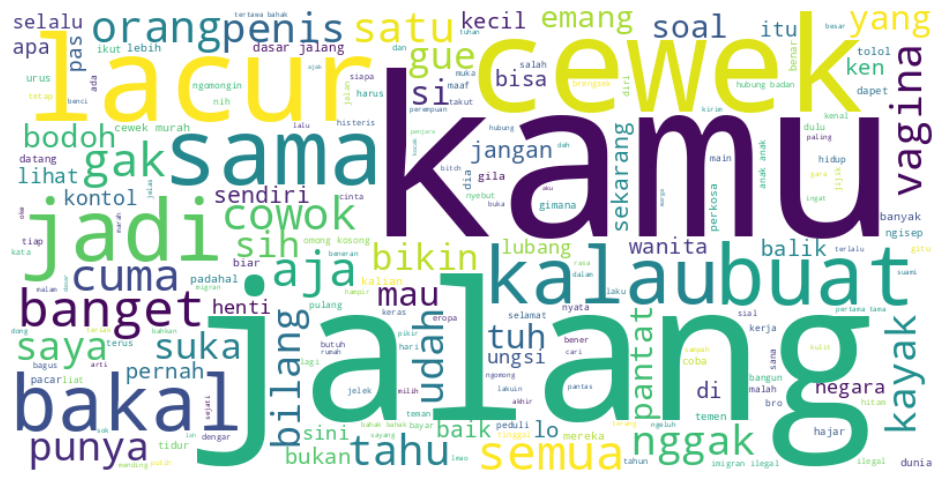

[('kamu', 188),
 ('jalang', 149),
 ('cewek', 104),
 ('lacur', 76),
 ('sama', 42),
 ('jadi', 36),
 ('buat', 34),
 ('kalau', 33),
 ('bakal', 33),
 ('banget', 32)]

In [18]:
hs_text = ' '.join(df_final[df_final["label"] == 1]["No Stopword Text"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hs_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Counter(hs_text.split()).most_common(10)